## Setup

#### Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import combined_data

%matplotlib inline

## Data Prepartaion

### Loading movie titles

In [2]:
columns = [0,1,2]
movies = pd.read_csv(
    "netflix-data/movie_titles.csv",
    encoding="ISO-8859-1",
    usecols=columns
)
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17770 entries, 0 to 17769
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      17770 non-null  int64  
 1   Year    17763 non-null  float64
 2   Title   17770 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 416.6+ KB


Only 7 titles have missing data so they are dropped and years converted to int values

In [3]:
movies.dropna(inplace=True)
movies.Year = movies.Year.astype(int)
movies

,ID,Year,Title
0,1,2003,Dinosaur Planet
1,2,2004,Isle of Man TT 2004 Review
2,3,1997,Character
3,4,1994,Paula Abdul's Get Up & Dance
4,5,2004,The Rise and Fall of ECW
...,...,...,...
17765,17766,2002,Where the Wild Things Are and Other Maurice Se...
17766,17767,2004,Fidel Castro: American Experience
17767,17768,2000,Epoch
17768,17769,2003,The Company


### Examining the ratings dataset

Converting `combined_data_n.txt` files into feather format if necessary and loading them for analysis. (Functions defined in `combined_data.py`) 

In [4]:
combined_data.initialize_all_data()
ratings = pd.read_feather(combined_data.combined_ratings_path())
ratings.head()

,movie,user,rating
0,1,1488844,3
1,1,822109,5
2,1,885013,4
3,1,30878,4
4,1,823519,3


In [5]:
ratings.dtypes

movie     int64
user      int64
rating    int64
dtype: object

In [6]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24053764 entries, 0 to 24053763
Data columns (total 3 columns):
 #   Column  Dtype
---  ------  -----
 0   movie   int64
 1   user    int64
 2   rating  int64
dtypes: int64(3)
memory usage: 550.5 MB


The dataset has no missing values

In [7]:
ratings.isna().sum()

movie     0
user      0
rating    0
dtype: int64

Dataframe shape (Over 24m ratings)

In [8]:
ratings.shape

(24053764, 3)

No duplicate ratings in the dataset

In [9]:
ratings.duplicated().any()

False

## Eploratory Data Analysis

### Ratings bar plot

In [10]:
ratings_count = ratings.rating.value_counts()
ratings_count

rating
4    8085741
3    6904181
5    5506583
2    2439073
1    1118186
Name: count, dtype: int64

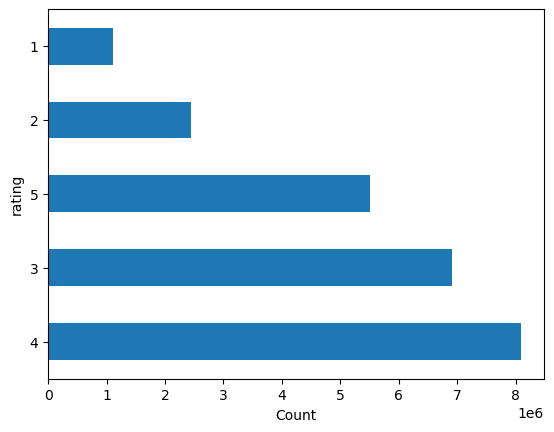

In [11]:
ratings_count.plot(kind="barh", xlabel="Count");

#### Observation

The vast majority of films are rated favorably or neutral<hr>

### Ratings box plot

In [12]:
ratings.rating.median()

4.0

In [13]:
q1 = np.percentile(ratings.rating, 25)
q3 = np.percentile(ratings.rating, 75)
iqr = q3 - q1
print(f"Q1: {q1}\nQ3:{q3}\nInterquartile Range:{iqr}")

Q1: 3.0
Q3:4.0
Interquartile Range:1.0


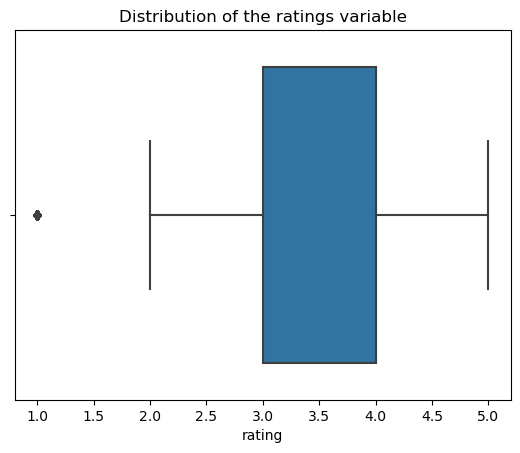

In [14]:
sns.boxplot(x='rating', data=ratings)
plt.title("Distribution of the ratings variable");

#### Observations
- The ratings have a median of 4 and an IQR of 1
- There appears to be outliers at the lower end of the ratings which might indicate class imbalance
<hr>

### Reducing rating categories (Negative: 0, Neutral: 1, Positive: 2)

In [15]:
ratings["category"] = ratings.rating.apply(
    lambda x:
        0 if x == 1 or x == 2 
        else(1 if x ==3 else 2)
)
ratings.head()

,movie,user,rating,category
0,1,1488844,3,1
1,1,822109,5,2
2,1,885013,4,2
3,1,30878,4,2
4,1,823519,3,1


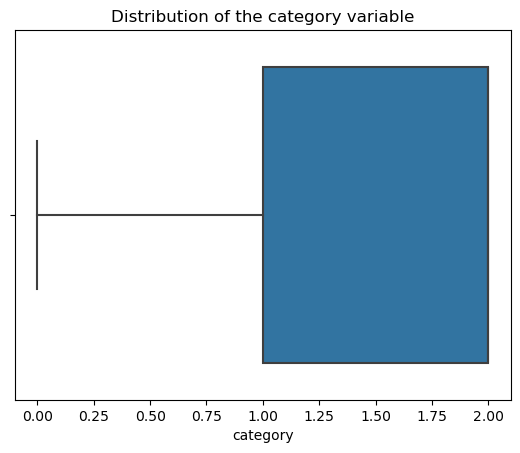

In [16]:
sns.boxplot(x='category', data=ratings)
plt.title("Distribution of the category variable");

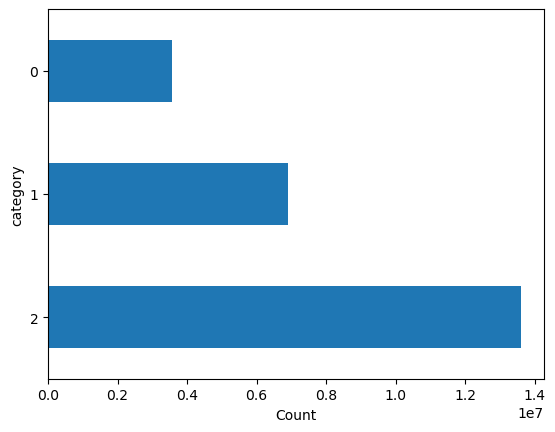

In [18]:
ratings_count = ratings.category.value_counts()
ratings_count.plot(kind="barh", xlabel="Count");

#### Observations
Reducing the categories reduces the strength of the outliers
<hr>

With our rating categories set, we can drop the original rating column

In [17]:
ratings.drop("rating", axis=1, inplace=True)
ratings

,movie,user,category
0,1,1488844,1
1,1,822109,2
2,1,885013,2
3,1,30878,2
4,1,823519,1
...,...,...,...
24053759,4499,2591364,0
24053760,4499,1791000,0
24053761,4499,512536,2
24053762,4499,988963,1


### Heatmap

In [23]:
ratings_corr =  ratings.corr()
ratings_corr

,movie,user,category
movie,1.000000,-0.000178,-0.015289
user,-0.000178,1.000000,-0.000426
category,-0.015289,-0.000426,1.000000


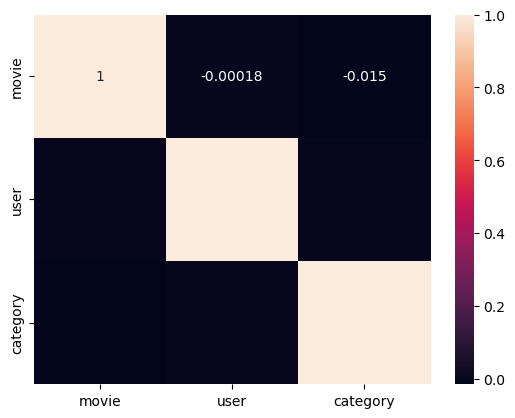

In [24]:
sns.heatmap(ratings_corr, annot=True);

#### Observations
There appears to be no strong correlation between any of the variables. This indicates a non-linear more omplex relationship

## Modeling